In [1]:
import sys
sys.path.append(".")

In [2]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
import matplotlib.pylab as plt
from pathlib import Path
from PlayingCardsGenerator import CardsDataGenerator

In [27]:
model_name_it = "VGG16_Scratch.h5"

In [28]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [29]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

In [30]:
monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

In [8]:
def scheduler(epoch, lr):
    if epoch%40 == 0 and epoch!= 0:
        lr = lr/2
    return lr

In [9]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [10]:
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "rotation_range":30,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "vertical_flip":True}

In [11]:
generator = CardsDataGenerator(**gen_params, validation_split=0.2,  preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [12]:
bs = 8 # batch size

In [13]:
path = Path("dataset/")

In [14]:
img_height = 240
img_width = 240

In [15]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]

In [16]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    interpolation="nearest",
    classes=classes_names) # set as training data

Found 24952 images belonging to 52 classes.


In [17]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    classes=classes_names) # set as validation data

Found 6206 images belonging to 52 classes.


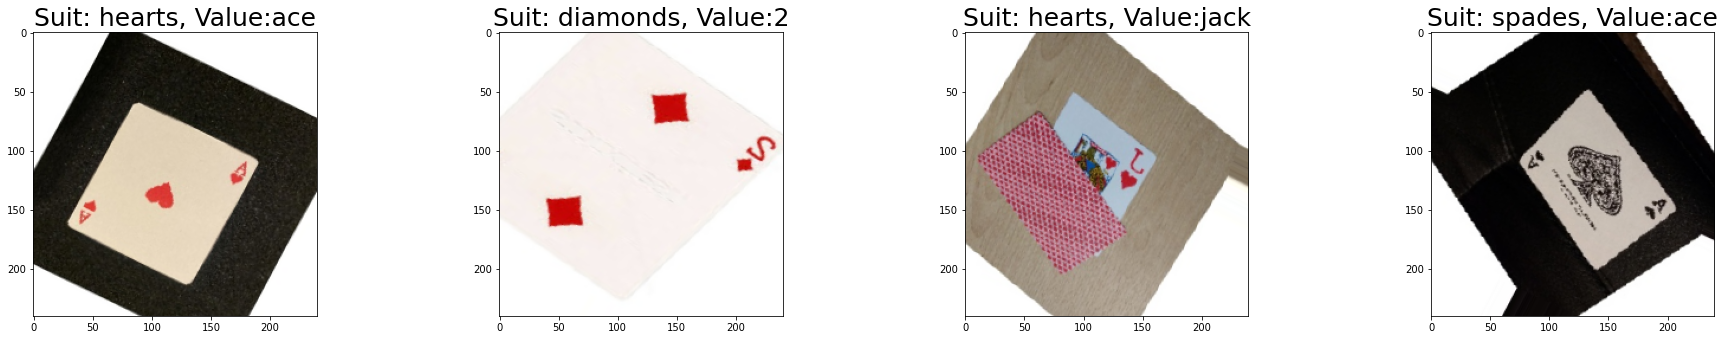

In [18]:
#Exploratory data analysis

plt.figure(figsize = (32,24))
Xbatch, Ybatch = validation_generator.__getitem__(0)

suits_names = train_generator.suits_names
values_names = train_generator.values_names
suits = Ybatch[0]
values = Ybatch[1]

for ii in range(int(bs/2)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    suit_idx = int(suits[ii].argmax())
    value_idx = int(values[ii].argmax())
    plt.title("Suit: {}, Value:{}".format(suits_names[suit_idx],values_names[value_idx]),\
              fontsize=25)
plt.show()

In [19]:
# Defining the model

trainable_flag = True
include_top_flag = False
weigths_value = 'imagenet'

if trainable_flag:
    include_top_flag = True
    weigths_value = None
else:
    include_top_flag = False
    weigths_value = 'imagenet'    


In [22]:
print(weigths_value)
print(include_top_flag)
print(trainable_flag)

base_model = tf.keras.applications.VGG16(
    weights=weigths_value, 
    input_tensor=None,
    
    pooling=None,
    classifier_activation="softmax",
    input_shape=(img_height, img_width, 3),
    include_top=include_top_flag,
    classes=len(suits_names) + len(values_names))

None
True
True


In [23]:
base_model.trainable = trainable_flag

In [24]:
x1 = base_model(base_model.input, training = trainable_flag)
#x3 = tf.keras.layers.GlobalAveragePooling2D()(x1)
#x4 = tf.keras.layers.Flatten()(x3)`
out1 = tf.keras.layers.Dense(len(suits_names), activation = 'softmax')(x1)
out2 = tf.keras.layers.Dense(len(values_names),activation = 'softmax')(x1)

model = tf.keras.Model(inputs = base_model.input, outputs = [out1,out2])

In [ ]:
print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb3 (Functional)    (None, 17)           10809664    ['input_2[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 4)            72          ['efficientnetb3[0][0]']         
                                                                                                  
 dense_3 (Dense)                (None, 13)           234         ['ef

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), #1e-4
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
 #model = tf.keras.models.load_model('model_name_it')

In [34]:
history_it = model.fit(train_generator, epochs=10, verbose = 1, \
                       workers=8, validation_data = (validation_generator),  callbacks= [monitor_it,early_stop, lr_schedule])

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
model.save('my_model.h5')

In [54]:
!jupyter nbconvert --to script train-talc.ipynb

[NbConvertApp] Converting notebook train-talc.ipynb to script
[NbConvertApp] Writing 4938 bytes to train-talc.py
